In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset from Excel
df = pd.read_excel('/content/y2.xlsx')

# Step 1: Clean the text data
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Step 2: Tokenization and stopword removal
def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Define stopwords
    filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords
    return filtered_words

# Apply cleaning and tokenization
df['Cleaned_Review'] = df['Review'].apply(clean_text)
df['Tokenized_Review'] = df['Cleaned_Review'].apply(tokenize_and_remove_stopwords)

# Step 3: Sentiment Analysis using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Review'].apply(get_sentiment)

# Step 4: Prepare data for LSTM (Tokenization and Padding)
max_words = 10000  # Maximum words to consider
max_len = 100  # Maximum length of each sequence

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Cleaned_Review'])  # Fit tokenizer on cleaned reviews

# Convert reviews to sequences
sequences = tokenizer.texts_to_sequences(df['Cleaned_Review'])
X = pad_sequences(sequences, maxlen=max_len)

# Step 5: Encode Sentiments
label_encoder = LabelEncoder()
df['Encoded_Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
y = df['Encoded_Sentiment'].values

# Step 6: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


X_train shape: (8000, 100)
X_test shape: (2000, 100)
y_train shape: (8000,)
y_test shape: (2000,)


In [ ]:
import numpy as np

# Load GloVe embeddings (make sure you have the glove file, e.g., glove.6B.100d.txt)
embeddings_index = {}
embedding_dim = 100  # Dimension of GloVe embeddings (100d)

# Load the GloVe embeddings into memory
with open('/content/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # First value is the word
        coefs = np.asarray(values[1:], dtype='float32')  # Remaining values are the word's vector
        embeddings_index[word] = coefs

# Create an embedding matrix where each word index corresponds to its GloVe vector
embedding_matrix = np.zeros((max_words, embedding_dim))  # Create a matrix of zeros for all tokens

for word, i in tokenizer.word_index.items():
    if i < max_words:  # Ensure we don't exceed the max words limit
        embedding_vector = embeddings_index.get(word)  # Get GloVe vector for the word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Assign GloVe vector to the embedding matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Define the LSTM Model with GloVe Embedding
model_glove = Sequential()

# GloVe Embedding Layer
model_glove.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))

# LSTM Layer
model_glove.add(LSTM(16, return_sequences=False))

# Fully Connected Layer
model_glove.add(Dense(8, activation='sigmoid'))

# Output Layer
model_glove.add(Dense(3, activation='sigmoid'))  # 3 classes: Positive, Negative, Neutral

# Compile the model using SGD optimizer
model_glove.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

# Step 2: Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Step 3: Train the model with class weights
history_lstm = model_glove.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Step 4: Evaluate the model
loss_glove, accuracy_glove = model_glove.evaluate(X_test, y_test)
print(f'Model Accuracy with LSTM: {accuracy_glove * 100:.2f}%')

# Step 5: Predict the sentiment classes for the test set
y_pred = model_glove.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest prediction probability

# Step 6: Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)






/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5218 - loss: 1.1029 - val_accuracy: 0.5165 - val_loss: 1.0731
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4683 - loss: 1.0828 - val_accuracy: 0.4950 - val_loss: 1.0662
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4691 - loss: 1.0509 - val_accuracy: 0.4980 - val_loss: 1.0498
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4902 - loss: 1.0671 - val_accuracy: 0.5255 - val_loss: 1.0210
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5073 - loss: 1.0231 - val_accuracy: 0.5195 - val_loss: 1.0134
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5236 - loss: 1.0079 - val_accuracy: 0.6130 - val_loss: 0.9654
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5944 - loss: 0.9866 - val_accuracy: 0.7030 - val_loss: 0.8821
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7181 - loss: 0.8920 - val_accuracy:

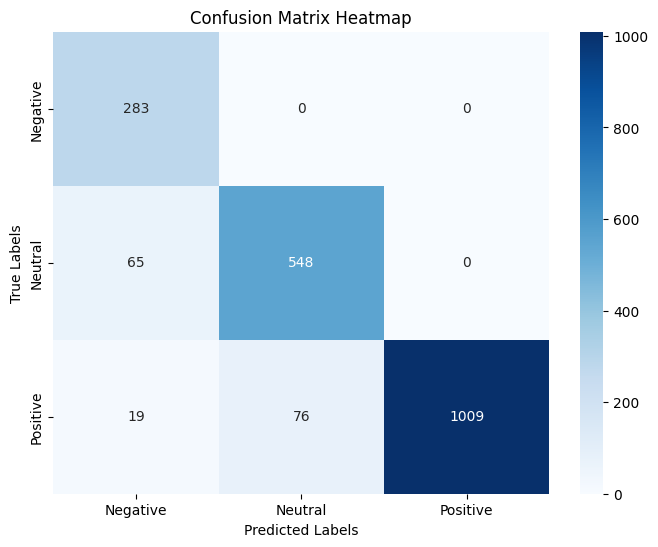

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
# Save the model in HDF5 format
model_glove.save('/content/sentiment_analysis_model.h5')

print("Model saved successfully.")


Model saved successfully.


In [ ]:
# Load new data
new_data_df = pd.read_excel('/content/y2.xlsx')  # Replace with the path to your new data file

# Step 1: Preprocess the new data
new_data_df['Cleaned_Review'] = new_data_df['Review'].apply(clean_text)  # Using the `clean_text` function from before

# Step 2: Convert new data to sequences and pad
new_sequences = tokenizer.texts_to_sequences(new_data_df['Cleaned_Review'])
new_X = pad_sequences(new_sequences, maxlen=max_len)

# Step 3: Use the loaded model to predict sentiment
new_y_pred = model_glove(new_X)
new_y_pred_classes = np.argmax(new_y_pred, axis=1)

# Step 4: Decode sentiment labels back to original classes
new_data_df['Predicted_Sentiment'] = label_encoder.inverse_transform(new_y_pred_classes)

# Display the results
print(new_data_df[['Review', 'Predicted_Sentiment']])


                                                 Review Predicted_Sentiment
0     Unfortunately, Miracle-Gro did not make much o...            Negative
1     No major difference in the Espoma issue even a...             Neutral
2     The Milorganite seems to be less significant i...            Negative
3     I noticed a substantial betterment in the crop...            Positive
4     Scotts Turf Builder has been remarkable in dea...            Positive
...                                                 ...                 ...
9995  The Jobe's Organics was somewhat controlled af...            Negative
9996  The Milorganite seems to be less significant i...             Neutral
9997  Unfortunately, Scotts Turf Builder did not mak...             Neutral
9998  The Milorganite was somewhat controlled after ...            Positive
9999  I noticed a major progress in the crop after u...            Positive

[10000 rows x 2 columns]


In [ ]:
# Step 5: Summarize sentiment counts by pesticide
# Assuming the new data includes a 'Pesticide' column
sentiment_summary = new_data_df.groupby(['Fertilizer', 'Predicted_Sentiment']).size().unstack(fill_value=0)

# Sort each pesticide by the count of positive sentiments in descending order
sentiment_summary = sentiment_summary.sort_values(by='Positive', ascending=False)

# Display the summarized results
print("Sentiment Summary by Pesticide:")
print(sentiment_summary)


Sentiment Summary by Pesticide:
Predicted_Sentiment  Negative  Neutral  Positive
Fertilizer                                      
BioAdvanced               212      353       570
GreenView                 189      343       538
Jobe's Organics           206      299       510
Espoma                    151      291       498
Osmocote                  147      323       485
Milorganite               196      307       482
Scotts Turf Builder       199      320       476
Miracle-Gro               193      291       451
FoxFarm                   239      346       445
Dyna-Gro                  167      332       441


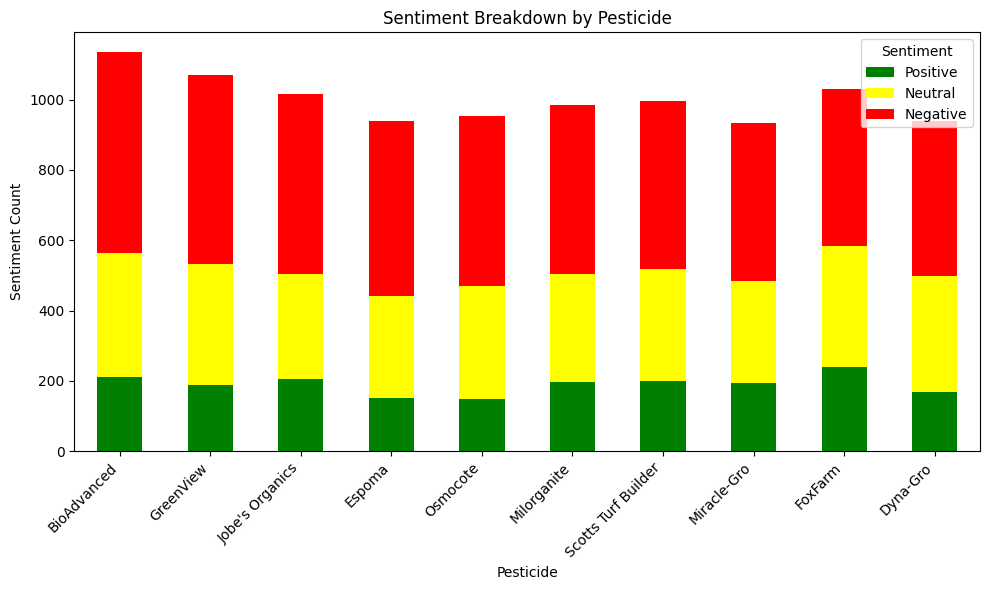

In [ ]:
import matplotlib.pyplot as plt

# Step 7: Visualize sentiment counts for each pesticide
def plot_sentiment_summary():
    sentiment_summary.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'yellow', 'red'])
    plt.title('Sentiment Breakdown by Pesticide')
    plt.xlabel('Pesticide')
    plt.ylabel('Sentiment Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Sentiment', labels=['Positive', 'Neutral', 'Negative'])
    plt.tight_layout()
    plt.show()

# Display the bar chart
plot_sentiment_summary()


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import ipywidgets as widgets
from IPython.display import display

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset (assuming it's an Excel file)
df = pd.read_excel('/content/y2.xlsx')

# Step 1: Text Cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Step 2: Tokenization and Stopword Removal function
def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Step 3: Apply Text Cleaning and Tokenization
df['Cleaned_Review'] = df['Review'].apply(clean_text)
df['Tokenized_Review'] = df['Cleaned_Review'].apply(tokenize_and_remove_stopwords)

# Step 4: Sentiment Analysis function using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Add the 'Sentiment' column to the DataFrame
df['Sentiment'] = df['Review'].apply(get_sentiment)

# Step 5: Define the disease selection and pesticide analysis functions

# Filter reviews by disease name
def filter_reviews_by_disease(disease_name):
    filtered_data = df[df['Disease Name'].str.contains(disease_name, case=False, na=False)]
    return filtered_data

# Calculate sentiment for each pesticide related to the selected disease
def get_sentiment_summary_for_disease(disease_name):
    filtered_data = filter_reviews_by_disease(disease_name)

    # Group by pesticide and calculate sentiment counts
    sentiment_counts = filtered_data.groupby('Fertilizer')['Sentiment'].value_counts().unstack(fill_value=0)

    # Sort pesticides by positive sentiment
    sentiment_counts['Total_Positive'] = sentiment_counts['Positive']
    sentiment_counts_sorted = sentiment_counts.sort_values('Total_Positive', ascending=False)

    return sentiment_counts_sorted

# Create a dropdown widget for selecting disease
disease_dropdown = widgets.Dropdown(
    options=df['Disease Name'].unique(),
    description='Select Disease:',
    disabled=False,
)

# Display best pesticide based on sentiment analysis
def display_best_pesticide(disease_name):
    sentiment_summary = get_sentiment_summary_for_disease(disease_name)

    # Display the sorted sentiment summary for the disease
    print(f"\nSentiment Summary for Disease: {disease_name}")
    display(sentiment_summary[['Total_Positive']])  # Show sorted pesticides by positive sentiment

    # Display the best pesticide (the one with the most positive sentiment)
    best_pesticide = sentiment_summary.index[0]
    print(f"\nThe best pesticide for {disease_name} based on positive sentiment is: {best_pesticide}")

# Step 6: Display the dropdown and the best pesticide output
widgets.interactive(display_best_pesticide, disease_name=disease_dropdown)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


interactive(children=(Dropdown(description='Select Disease:', options=('Rust', 'Downy Mildew', 'Leaf Curl', 'B…

**Bi**-**Lstm**

In [ ]:
from textblob import TextBlob

# Function to classify sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    # If polarity > 0, it's positive, if 0, it's neutral, if < 0, it's negative
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the function to generate sentiment labels
df['Sentiment'] = df['Review'].apply(get_sentiment)

# Verify that the Sentiment column has been added
print(df.columns)


Index(['Disease Name', 'Fertilizer', 'Review', 'Cleaned_Review',
       'Tokenized_Review', 'Sentiment'],
      dtype='object')


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Tokenize the reviews (Cleaned_Review)
max_words = 10000  # You can adjust this based on your dataset
max_len = 100  # Maximum length for padding sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Cleaned_Review'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['Cleaned_Review'])

# Pad sequences to ensure uniform input length
X = pad_sequences(sequences, maxlen=max_len)

# Step 2: Encode the sentiment labels
label_encoder = LabelEncoder()
df['Encoded_Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Get the encoded sentiment labels
y = df['Encoded_Sentiment'].values

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (8000, 100)
X_test shape: (2000, 100)
y_train shape: (8000,)
y_test shape: (2000,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

# Define the BiLSTM model
model_bilstm = Sequential()

# GloVe embedding layer (can use pre-trained embeddings or random initialization)
embedding_dim = 100  # Dimension of GloVe embeddings
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)
model_bilstm.add(embedding_layer)

# Add a Bi-directional LSTM layer
model_bilstm.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))

# Fully connected layer
model_bilstm.add(Dense(64, activation='relu'))

# Output layer with softmax activation (3 classes: Positive, Neutral, Negative)
model_bilstm.add(Dense(3, activation='softmax'))

# Compile the model
model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model architecture
model_bilstm.summary()

# Step 5: Train the BiLSTM model
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Step 6: Evaluate the model
loss_bilstm, accuracy_bilstm = model_bilstm.evaluate(X_test, y_test)
print(f'Model Accuracy with BiLSTM: {accuracy_bilstm * 100:.2f}%')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 735ms/step - accuracy: 0.7231 - loss: 0.6503 - val_accuracy: 0.9870 - val_loss: 0.0390
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 659ms/step - accuracy: 0.9897 - loss: 0.0466 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - accuracy: 0.9983 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 652ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 4.6741e-04
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 710ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 1.4324e-04
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 651ms/step - accuracy: 1.0000 - loss: 4.4291e-04 - val_accuracy: 1.0000 - val_loss: 3.4072e-04
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 654ms/step - accuracy: 0.9999 - loss: 6.7034e-04 - val_accuracy: 1.0000 - val_loss: 1.7528e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 704ms/step - accuracy: 1.0000 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step


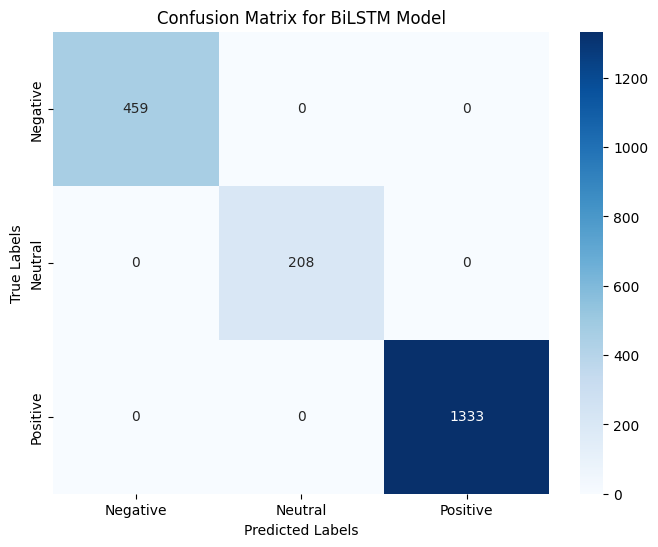

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       459
     Neutral       1.00      1.00      1.00       208
    Positive       1.00      1.00      1.00      1333

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict the classes for the test set
y_pred = model_bilstm.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels

# Step 2: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for BiLSTM Model')
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))


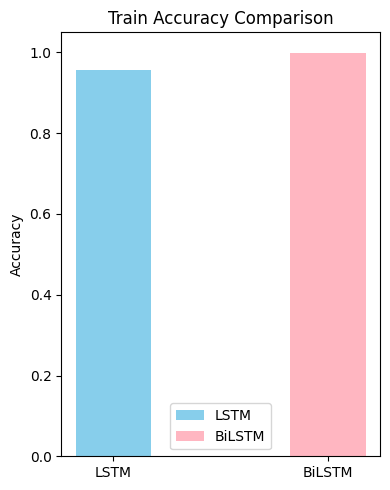

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the final train accuracy from the histories
lstm_train_accuracy = history_lstm.history['accuracy'][-1]
bilstm_train_accuracy = history_bilstm.history['accuracy'][-1]

# Set up the bar width and index for 2 bars
bar_width = 0.35
index = np.arange(2)  # We now have two bars: LSTM and BiLSTM

# Create bar plot for train accuracy comparison with different colors
plt.figure(figsize=(4, 5))
plt.bar(index[0], lstm_train_accuracy, bar_width, label='LSTM', color='skyblue')  # LSTM in blue
plt.bar(index[1], bilstm_train_accuracy, bar_width, label='BiLSTM', color='lightpink')  # BiLSTM in orange

# Adding the accuracy values for LSTM and BiLSTM
plt.xticks(index, ['LSTM', 'BiLSTM'])
plt.title('Train Accuracy Comparison')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


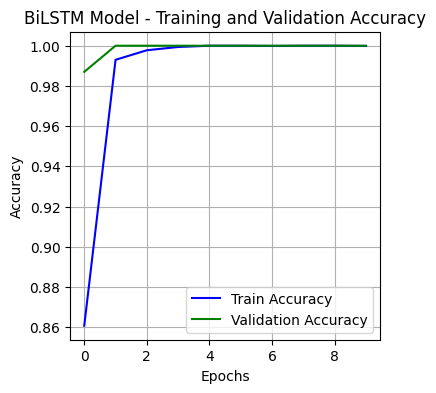

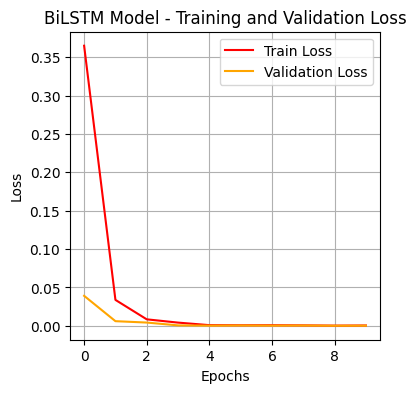

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history_bilstm' is the history object from the training of your BiLSTM model

# Plotting Training and Validation Accuracy
plt.figure(figsize=(4, 4))
plt.plot(history_bilstm.history['accuracy'], label='Train Accuracy', color='b')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy', color='g')
plt.title('BiLSTM Model - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(4, 4))
plt.plot(history_bilstm.history['loss'], label='Train Loss', color='r')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss', color='orange')
plt.title('BiLSTM Model - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


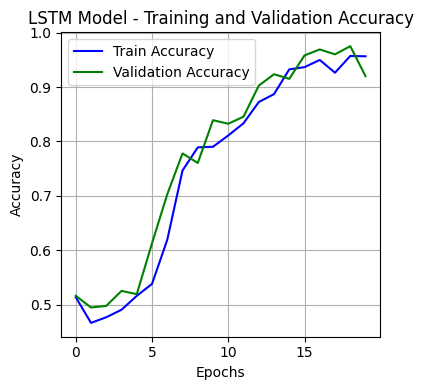

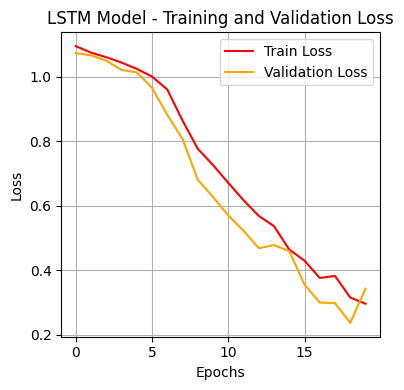

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history_lstm' is the history object from the training of your LSTM model

# Plotting Training and Validation Accuracy
plt.figure(figsize=(4, 4))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy', color='b')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', color='g')
plt.title('LSTM Model - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(4, 4))
plt.plot(history_lstm.history['loss'], label='Train Loss', color='r')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Model - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [ ]:
!pip install torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [ ]:
!pip install gradio

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import tensorflow as tf
import numpy as np

# Load dataset (Only for dropdowns, NOT for prediction)
df = pd.read_excel("/content/y2.xlsx")  # Update with correct path

# Load trained model
model = tf.keras.models.load_model("/content/sentiment_analysis_model.h5")  # Update with correct model path

# Function to get available pesticides for selected disease
def get_pesticides(disease):
    filtered_pesticides = df[df["Disease Name"] == disease]["Pesticide"].unique().tolist()
    return filtered_pesticides if filtered_pesticides else ["No Pesticides Available"]

# Function to preprocess input for model
def preprocess_text(text):
    # Apply the same text preprocessing used during training
    return text.lower()

# Function to predict sentiment using trained model
def predict_sentiment(disease, pesticide):
    if pesticide == "No Pesticides Available":
        return "No data available.", None

    # Get all reviews for the selected pesticide
    reviews = df[(df["Disease Name"] == disease) & (df["Pesticide"] == pesticide)]["Review"].tolist()

    if not reviews:
        return "No reviews available.", None

    # Preprocess reviews
    processed_reviews = [preprocess_text(review) for review in reviews]

    # Convert to model input format (Assuming tokenizer was used in training)
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(processed_reviews)
    sequences = tokenizer.texts_to_sequences(processed_reviews)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=100)

    # Predict sentiments
    predictions = model.predict(padded_sequences)
    predicted_labels = np.argmax(predictions, axis=1)  # Assuming model outputs softmax probabilities

    # Map labels to sentiment categories
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment_counts = pd.Series([sentiment_mapping[label] for label in predicted_labels]).value_counts()

    # Generate Pie Chart
    plt.figure(figsize=(5, 5))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
    plt.title(f"Sentiment Distribution for {pesticide}")
    plt.savefig("sentiment_pie_chart.png")
    plt.close()

    # Get recommended pesticides based on positive sentiment count
    sorted_pesticides = (
        df[df["Disease Name"] == disease]
        .groupby("Pesticide")["Sentiment"]
        .apply(lambda x: (x == "Positive").sum())
        .sort_values(ascending=False)
        .index.tolist()
    )

    # Remove selected pesticide from recommendations
    if pesticide in sorted_pesticides:
        sorted_pesticides.remove(pesticide)

    recommendations = ", ".join(sorted_pesticides) if sorted_pesticides else "None"
    return f"Recommended Pesticides: {recommendations}", "sentiment_pie_chart.png"

# Define Gradio Interface
disease_list = df["Disease Name"].unique().tolist()

with gr.Blocks() as demo:
    gr.Markdown("## 🌾 Pesticide Sentiment Analysis using Trained Model")

    disease_dropdown = gr.Dropdown(label="Select Disease", choices=disease_list, interactive=True)
    pesticide_dropdown = gr.Dropdown(label="Select Pesticide", choices=["Select a Disease First"], interactive=True)

    def update_pesticide_dropdown(disease):
        return gr.Dropdown.update(choices=get_pesticides(disease))

    disease_dropdown.change(update_pesticide_dropdown, inputs=disease_dropdown, outputs=pesticide_dropdown)

    output_text = gr.Textbox(label="Recommended Pesticides")
    output_image = gr.Image(label="Sentiment Pie Chart", type="filepath")

    analyze_button = gr.Button("Analyze Sentiment")
    analyze_button.click(predict_sentiment, inputs=[disease_dropdown, pesticide_dropdown], outputs=[output_text, output_image])

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://56eb08bc7feb5e00e9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import os
print(os.path.exists("/content/sentiment_analysis_model.h5"))


True


In [ ]:
import pandas as pd
df = pd.read_excel("/content/y2.xlsx")  # Update if needed
print(df.head())
print(df.columns)  # Confirm correct column names


   Disease Name            Pesticide  \
0          Rust          Miracle-Gro   
1  Downy Mildew               Espoma   
2          Rust          Milorganite   
3     Leaf Curl             Dyna-Gro   
4        Blight  Scotts Turf Builder   

                                              Review  
0  Unfortunately, Miracle-Gro did not make much o...  
1  No major difference in the Espoma issue even a...  
2  The Milorganite seems to be less significant i...  
3  I noticed a substantial betterment in the crop...  
4  Scotts Turf Builder has been remarkable in dea...  
Index(['Disease Name', 'Pesticide', 'Review'], dtype='object')


In [ ]:
disease_name = "Your_Disease"  # Replace with an actual disease name
print(df[df["Disease Name"] == disease_name]["Pesticide"])


Series([], Name: Pesticide, dtype: object)


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/sentiment_analysis_model.h5")
print(model.summary())  # To check if the model is correctly loaded


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, 100, 100)              │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (64, 16)                    │           7,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, 8)                     │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (64, 3)                     │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,007,653 (3.84 MB)

 Trainable params: 7,651 (29.89 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 2 (12.00 B)

None
